# Pairs Trading on MSFT And ADBE using ML

*Author: Tejas Narendra Chaudhari*

### Strategy

The strategy involves taking market neutral positions on a pair of co-integrated stocks. 

Here, we have choosen historical data of ADBE and MSFT for testing the strategy. We begin by verifying that the pair of stocks is indeed co-integrated. 

After that, we find the price-ratio of the two stocks. Price ratio of two stocks is defined as $Price Ratio = \frac{price\_of\_stock 1}{price\_of\_stock 2}$.

Now, we use multi-variate polynomial regression to predict the future price ratio of the stock based on input variables like Moving Averages, Rate of Change, Volatility, Relative Strength Index, etc. 

The future price ratio is used to generate a trading signal. If the predicted price ratio is significantly greater than the current price ratio, then we buy stock 1 and sell stock 2, and vice-versa.

In [37]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

Fetch the data using Yahoo Finance API. <br>
We are using interval from 2014 to 2019 because the stocks had significant Conitegration in this period.


In [38]:
stock2 = pd.DataFrame(yf.download('MSFT',start='2014-01-01',end='2019-01-01'))
stock1 = pd.DataFrame(yf.download('ADBE',start='2014-01-01',end='2019-01-01')) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [39]:
stock1.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,59.060001,59.529999,58.939999,59.290001,59.290001,2745900
2014-01-03,59.189999,59.689999,59.110001,59.160000,59.160000,1589000
2014-01-06,58.060001,58.770000,58.009998,58.119999,58.119999,3753600
2014-01-07,58.259998,59.049999,58.060001,58.970001,58.970001,2963600
2014-01-08,59.119999,59.279999,58.459999,58.900002,58.900002,3456000


In [40]:
stock2.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-24,97.680000,97.970001,93.980003,94.129997,88.722137,43935200
2018-12-26,95.139999,100.690002,93.959999,100.559998,94.782692,51634800
2018-12-27,99.300003,101.190002,96.400002,101.180000,95.367104,49498500
2018-12-28,102.089996,102.410004,99.519997,100.389999,94.622490,38196300
2018-12-31,101.290001,102.400002,100.440002,101.570000,95.734703,33173800


Visualizing the Data

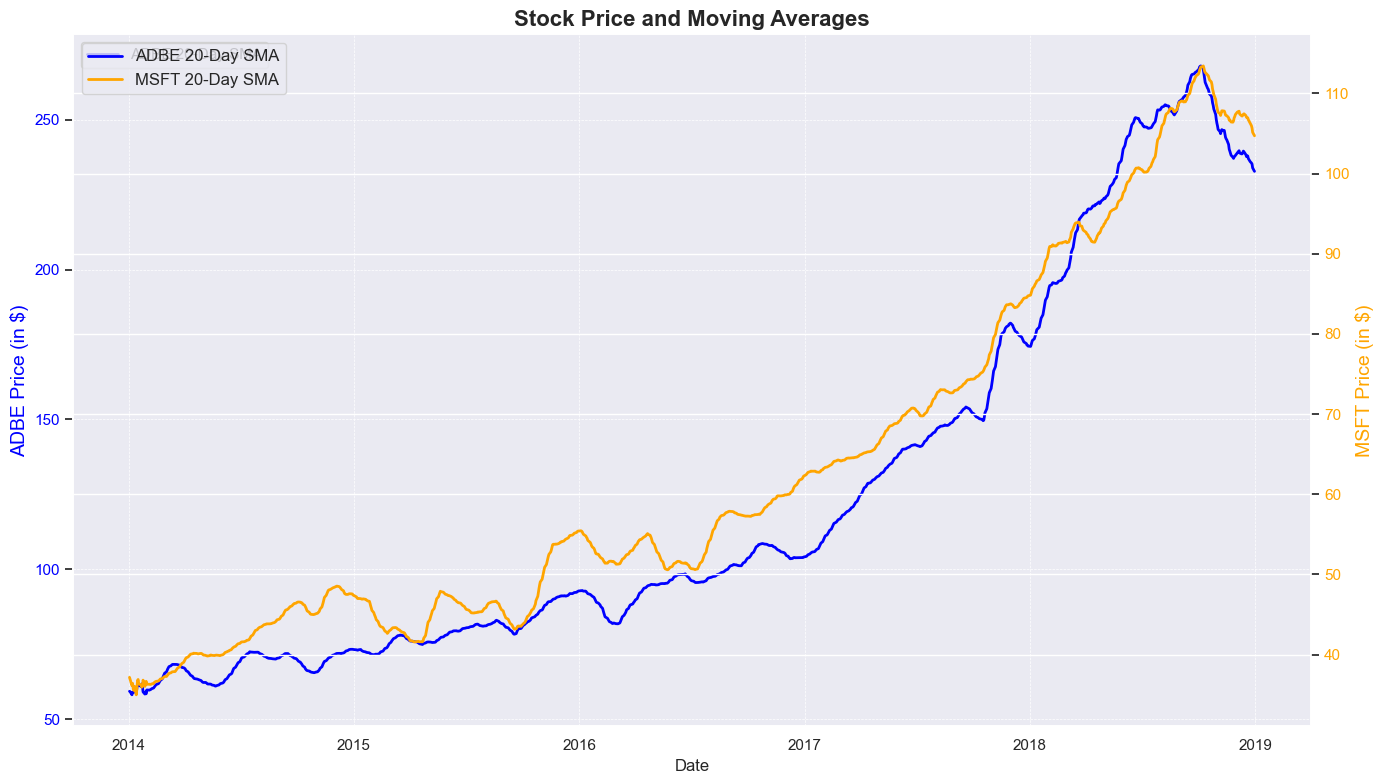

In [41]:
import warnings
warnings.filterwarnings('ignore')

# Add moving averages for better visualization
stock1['SMA_20'] = stock1['Close'].rolling(window=20).mean()
stock2['SMA_20'] = stock2['Close'].rolling(window=20).mean()
stock1['SMA_20'].fillna(stock1['Close'], inplace=True)
stock2['SMA_20'].fillna(stock2['Close'], inplace=True)

# Set theme
sns.set_theme(style='darkgrid')

# Plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot ADBE
sns.lineplot(data=stock1, x=stock1.index, y='SMA_20', ax=ax1, label='ADBE 20-Day SMA', color='blue', linewidth=2)
ax1.set_ylabel("ADBE Price (in $)", fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot MSFT on the same plot with a secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(data=stock2, x=stock2.index, y='SMA_20', ax=ax2, label='MSFT 20-Day SMA', color='orange', linewidth=2)
ax2.set_ylabel("MSFT Price (in $)", fontsize=14, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add title and labels
plt.title("Stock Price and Moving Averages", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Testing For Cointegration

In [42]:
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm

We will use the Augnemted Engle Granger Test 

In [43]:
(_,p_value,__) = coint(stock1['Close'], stock2['Close'], trend='ct', method='aeg') # Note: only one method is available for testing CoIntegration in statsmodels
p_value


0.00751669060365914

The Null Hypothesis that the pair of stocks are not cointegrated will be rejected if we take a threshold of 1%. Therefore, it is safe to assume that the two stocks are cointegrated. 

In [44]:
# Finding the correlation
print('{:.2f}'.format(stock1['Close'].corr(stock2['Close'])*100))

98.95


The stocks also have a 98.95% correlation. 

Now we find the the price ratio $b$ in $ s2 = b \cdot s1 + a + \epsilon $

In [45]:
import statsmodels.api as sm 

In [46]:
s1 = stock1['Close']
s2 = stock2['Close']

s1 = sm.add_constant(s1) 
results = sm.OLS(s2,s1).fit() # y = b * x + a + err (y is a datapoint in s2 and  x is in s1)

In [47]:
b = results.params['Close']

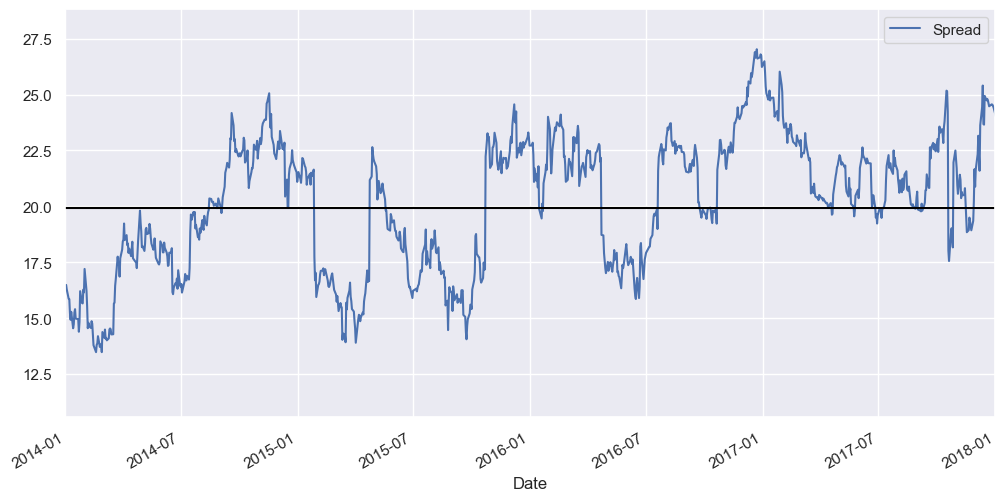

In [48]:
spread = s2 - b * s1['Close'] 
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2014-01-01', '2018-01-01')
plt.legend(['Spread'])

Spread between the two stocks is showing mean reverting behaviour.

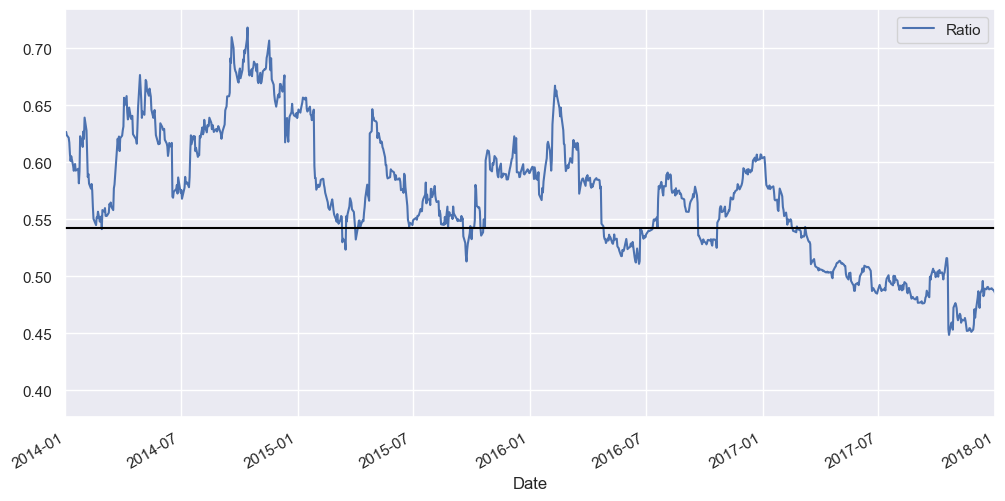

In [49]:
ratio = s2/s1['Close']
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2014-01-01', '2018-01-01')
plt.legend(['Ratio'])
plt.show()

In [50]:
del s1 
del s2
del spread

## Traning Model for Predicting Future Ratios

Create input features for the ML Model. We will be using:
- 5 Day Moving Average
- 20 Day Moving Average
- 50 Day Moving Average
- 14 Day Relative Strength Index
- Lagging Rate of Change (window 3)
- Lagging Standard Deviation indicating Volatility (window 14) 

In [51]:
def ma(series, window):
    return series.rolling(window=window).mean()

# Rate of Change (ROC)
def roc(series, window):
	return series.pct_change(window)

def rsi(series, window):
	delta = series.diff()
	gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
	loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
	rs = gain / loss
	return 100 - (100 / (1 + rs))

# Standared Deviation
def std(series, window):
	return series.rolling(window=window).std()

# Exponential Moving Average (EMA)
def EMA(series, window):
	return series.ewm(span=window, adjust=False).mean()

### Data Preparation

In [52]:
ratio = stock2['Close'] / stock1['Close']
ma5 = ma(ratio, 5)
ma20 = ma(ratio, 20)
ma50 = ma(ratio, 50)
rsi_14 = rsi(ratio, 14)
roc_3 = roc(ratio, 3)
volatility = std(ratio, 14)
ema_14 = EMA(ratio, 14)
target = ema_14.shift(-14)

In [53]:
len(ratio), len(ma5), len(ma20), len(roc_3), len(volatility), len(rsi_14), len(ma50), len(target)

(1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258)

In [54]:
train_test_split = 0.7
split = int(train_test_split * len(ratio))

In [55]:
train_data = pd.DataFrame({'ratio':ratio.iloc[50:split], 'ma5':ma5.iloc[50:split], 'ma20':ma20.iloc[50:split],  'roc_3':roc_3.iloc[50:split], 'volatility':volatility.iloc[50:split], 'ma50':ma50.iloc[50:split], 'rsi_14' : rsi_14.iloc[50:split]})

test_data = pd.DataFrame({'ratio':ratio.iloc[split:-20], 'ma5':ma5.iloc[split:-20], 'ma20':ma20.iloc[split:-20],'roc_3':roc_3.iloc[split:-20], 'volatility':volatility.iloc[split:-20], 'ma50':ma50.iloc[split:-20], 'rsi_14' : rsi_14.iloc[split:-20]})

In [56]:
train_data['future_ratio'] = target.iloc[50:split]
test_data['future_ratio'] = target.iloc[split:-20]

In [57]:
test_data

,ratio,ma5,ma20,roc_3,volatility,ma50,rsi_14,future_ratio
Date,,,,,,,,
2017-06-30,0.487344,0.485944,0.498286,0.003700,0.010096,0.501047,16.766057,0.493742
2017-07-03,0.492522,0.487139,0.497743,0.014751,0.009383,0.500800,28.819991,0.493537
2017-07-05,0.489200,0.487870,0.496851,0.008829,0.008462,0.500421,25.779802,0.494476
2017-07-06,0.487176,0.488232,0.496008,-0.000346,0.007215,0.499988,24.505668,0.494464
2017-07-07,0.488398,0.488928,0.495206,-0.008373,0.005345,0.499540,26.957791,0.495257
...,...,...,...,...,...,...,...,...
2018-11-23,0.456952,0.461128,0.447182,-0.040454,0.008788,0.436954,59.039051,0.446359
2018-11-26,0.459002,0.462267,0.448375,-0.008392,0.008882,0.437879,57.315918,0.448813
2018-11-27,0.461313,0.459286,0.449783,0.011033,0.009009,0.438745,58.897104,0.450262


### Predicting Future Price Ratio using Polynomial Regression using Ridge

Polynomial Regression Mean Squared Error: 0.0002103244743816501
Polynomial Regression Mean Absolute Error: 0.011882329025721403
Polynomial Regression Mean Absolute Percentage Error: 2.6743652900522408%


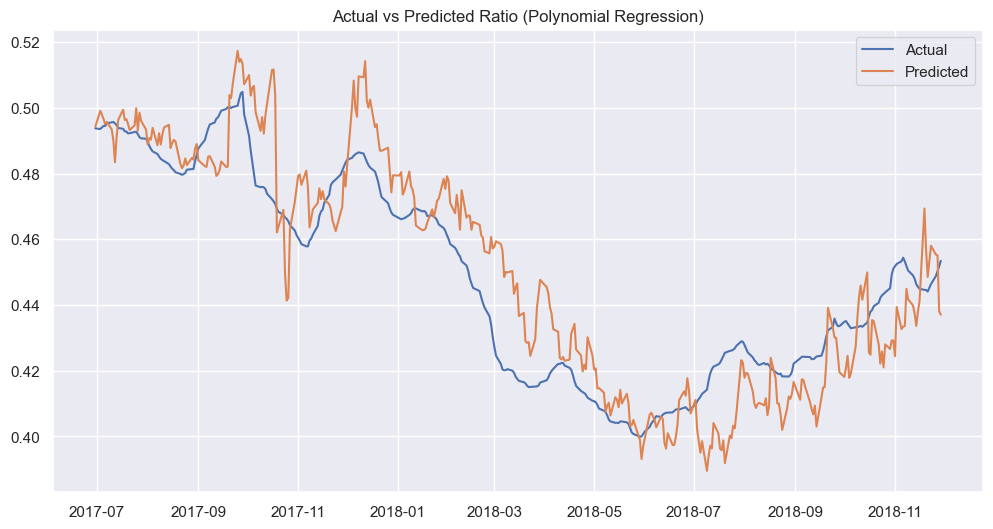

In [58]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Split the data into features and target
X_train = train_data.drop('future_ratio', axis=1)
y_train = train_data['future_ratio']
X_test = test_data.drop('future_ratio', axis=1)
y_test = test_data['future_ratio']

# Define the degree of the polynomial
degree = 2

# Create a pipeline with scaling, polynomial features, and ridge regression
poly_model = make_pipeline(StandardScaler(), PolynomialFeatures(degree), Ridge(alpha=0.1))

# Fit the model on the training data
poly_model.fit(X_train, y_train)

# Make predictions
y_pred_poly = poly_model.predict(X_test)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mape = mean_absolute_percentage_error(y_test, y_pred_poly)
print('Polynomial Regression Mean Squared Error:', mse_poly)
print('Polynomial Regression Mean Absolute Error:', mae_poly)
print('Polynomial Regression Mean Absolute Percentage Error: ', mape*100, '%', sep='')

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_poly, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Ratio (Polynomial Regression)')
plt.show()

### Using the Predictions to Generate Signals

In [60]:
def generate_signals(data):
    data['predicted_ratio'] = poly_model.predict(data.drop('future_ratio', axis=1))
    data['signal'] = np.where(data['predicted_ratio'] - data['ratio'] > 0.01, 1, 0)
    data['signal'] = np.where(data['predicted_ratio'] - data['ratio'] < -0.01, -1, data['signal'])
    return data

In [61]:
generate_signals(test_data)

,ratio,ma5,ma20,roc_3,volatility,ma50,rsi_14,future_ratio,predicted_ratio,signal
Date,,,,,,,,,,
2017-06-30,0.487344,0.485944,0.498286,0.003700,0.010096,0.501047,16.766057,0.493742,0.494260,0
2017-07-03,0.492522,0.487139,0.497743,0.014751,0.009383,0.500800,28.819991,0.493537,0.499064,0
2017-07-05,0.489200,0.487870,0.496851,0.008829,0.008462,0.500421,25.779802,0.494476,0.496657,0
2017-07-06,0.487176,0.488232,0.496008,-0.000346,0.007215,0.499988,24.505668,0.494464,0.495003,0
2017-07-07,0.488398,0.488928,0.495206,-0.008373,0.005345,0.499540,26.957791,0.495257,0.495716,0
...,...,...,...,...,...,...,...,...,...,...
2018-11-23,0.456952,0.461128,0.447182,-0.040454,0.008788,0.436954,59.039051,0.446359,0.458014,0
2018-11-26,0.459002,0.462267,0.448375,-0.008392,0.008882,0.437879,57.315918,0.448813,0.455326,0
2018-11-27,0.461313,0.459286,0.449783,0.011033,0.009009,0.438745,58.897104,0.450262,0.455110,0


In [62]:
test_data['signal'].value_counts()

signal
 0    252
 1     63
-1     43
Name: count, dtype: int64

In [63]:
test_data

,ratio,ma5,ma20,roc_3,volatility,ma50,rsi_14,future_ratio,predicted_ratio,signal
Date,,,,,,,,,,
2017-06-30,0.487344,0.485944,0.498286,0.003700,0.010096,0.501047,16.766057,0.493742,0.494260,0
2017-07-03,0.492522,0.487139,0.497743,0.014751,0.009383,0.500800,28.819991,0.493537,0.499064,0
2017-07-05,0.489200,0.487870,0.496851,0.008829,0.008462,0.500421,25.779802,0.494476,0.496657,0
2017-07-06,0.487176,0.488232,0.496008,-0.000346,0.007215,0.499988,24.505668,0.494464,0.495003,0
2017-07-07,0.488398,0.488928,0.495206,-0.008373,0.005345,0.499540,26.957791,0.495257,0.495716,0
...,...,...,...,...,...,...,...,...,...,...
2018-11-23,0.456952,0.461128,0.447182,-0.040454,0.008788,0.436954,59.039051,0.446359,0.458014,0
2018-11-26,0.459002,0.462267,0.448375,-0.008392,0.008882,0.437879,57.315918,0.448813,0.455326,0
2018-11-27,0.461313,0.459286,0.449783,0.011033,0.009009,0.438745,58.897104,0.450262,0.455110,0


In [64]:
# Add the original stock prices to the test data (for backtesting)
test_data['stock1_price'] = stock1['Close'].iloc[split:-20] 
test_data['stock2_price'] = stock2['Close'].iloc[split:-20]

### Backtesting the Strategy

In [65]:
def trade(data):
	"""
	Function that backtests the trading strategy. 
	Data should contain the following series:
	- signal: the trading signal (1, -1, or 0)
	- stock1_price: the price of stock1
	- stock2_price: the price of stock2
	- ratio: the ratio of stock2 to stock1
	The result object can be indexed to get the following:
	- 0: the final amount of money
	- 1: the exposure added on that buy signal (index will be the date of the buy)
	- 2: the exposure added on that sell signal (index will be the date of the sell)
	- 3: the cummulative profit or loss at that square-off  (index will be the date of the square off)
	- 4: the total cash at each time step 
	- 5: the M2M profit at each time step
	- 5: the maximum drawdown
	- 6: the peak profit
	- 7: the peak loss
	- 8: hit rate
	- 9: maximum exposure
	- 10: exposure at each time step
	"""
				
	# return money, buys, sells, square_offs, paisa, current_profit, max_drawdown, peak_profit, peak_loss
	money = 0
	countS1 = 0
	countS2 = 0 
	count1 = pd.Series(dtype='float64')
	count2 = pd.Series(dtype='float64')
	
	# Buy signal: buy stock2 and sell stock1
	# Sell signal: sell stock2 and buy stock1
	# Square off: close the position
	buys = pd.Series(dtype='float64')
	sells = pd.Series(dtype='float64')
	square_offs = pd.Series(dtype='float64')
	current_profit = []
	paisa = []
	exposure = pd.Series(dtype='float64')

	max_exposure = 0
	for i in range(len(data)):

		date = data.index[i]

		if data.iloc[i]['signal'] == 1:  # Buy stock2 and sell stock1
			if (countS1 > 0 or countS2 < 0):
				# first square off the position
				money += countS1 * data.iloc[i]['stock1_price'] + countS2 * data.iloc[i]['stock2_price']
				square_offs.at[date] = money
				countS1 = 0
				countS2 = 0


			money += data.iloc[i]['stock1_price'] * data.iloc[i]['ratio'] - data.iloc[i]['stock2_price'] 
			countS1 -= data.iloc[i]['ratio']
			countS2 += 1
			buys.at[date] = -1 *data.iloc[i]['stock1_price'] * data.iloc[i]['ratio'] + data.iloc[i]['stock2_price'] # Exposure added due to buy


		elif data.iloc[i]['signal'] == -1:  # Sell stock2 and buy stock1
			if (countS1 < 0 or countS2 > 0):
				# first square off the position
				money += countS1 * data.iloc[i]['stock1_price'] + countS2 * data.iloc[i]['stock2_price']
				square_offs.at[date] = money
				countS1 = 0
				countS2 = 0


			money -= data.iloc[i]['stock1_price'] * data.iloc[i]['ratio'] - data.iloc[i]['stock2_price'] 
			countS1 += data.iloc[i]['ratio']
			countS2 -= 1
			sells.at[date] = data.iloc[i]['stock1_price']  * data.iloc[i]['ratio'] - data.iloc[i]['stock2_price'] # Exposure added due to sell

		elif data.iloc[i]['signal'] == 0:  # Square off
			money += countS1 * data.iloc[i]['stock1_price'] + countS2 * data.iloc[i]['stock2_price']
			if countS1 != 0 or countS2 != 0:
				square_offs.at[date] = money # Money will give the profit or loss at that square off
			countS1 = 0
			countS2 = 0
		
		exposure.at[date] = countS1 * data.iloc[i]['stock1_price'] + countS2 * data.iloc[i]['stock2_price']
		max_exposure = max(abs(max_exposure), abs(countS1 * data.iloc[i]['stock1_price'] + countS2 * data.iloc[i]['stock2_price']))

		paisa.append(money) # Total cash at each time step
		current_profit.append(money + countS1 * data.iloc[i]['stock1_price'] + countS2 * data.iloc[i]['stock2_price']) # M2M profit

		count1.at[date] = countS1
		count2.at[date] = countS2

	# Square off the remaining positions
	trade_profit = countS1 * data.iloc[i]['stock1_price'] + countS2 * data.iloc[i]['stock2_price']
	money += trade_profit
	current_profit.append(money)
	paisa.append(money)

	paisa = pd.Series(paisa)

	# Find peak profit and peak loss
	current_profit = pd.Series(current_profit)
	peak_profit = current_profit.max()
	peak_loss = current_profit.min()
	
	# Find max drawdown and hit rate
	drawdown, max_drawdown = 0, 0
	hits, losses = 0, 0
	for i in range(1, len(current_profit)):
		if current_profit[i] > current_profit[i-1]:
			drawdown = 0
			hits+=1
		elif current_profit[i] < current_profit[i-1]:
			drawdown += current_profit[i-1] - current_profit[i]
			losses+=1
			if drawdown > max_drawdown:
				max_drawdown = drawdown

	hit_rate = hits / (hits + losses) * 100

	# Convert indices of paisa and current_profit to datetime
	# start_date = data.index[0]
	# new_dates = pd.date_range(start=start_date, periods=len(current_profit), freq='D')
	# paisa.index = new_dates
	# current_profit.index = new_dates
	dates = data.index.to_list()
	dates.append(data.index[-1] + pd.Timedelta(days=1))
	paisa.index = dates
	current_profit.index = dates

	return money, buys, sells, square_offs, paisa, current_profit, max_drawdown, peak_profit, peak_loss, hit_rate, max_exposure, exposure, count1, count2

In [66]:
results = trade(test_data)
print("Maximum Drawdown: ", results[6])
print("Peak Profit: ", results[7])
print("Peak Loss: ", results[8])
print("Hit Rate: ", results[9])
print("Maximum Exposure: ", results[10])
print("Final Amount: ", results[0])

Maximum Drawdown:  64.09869803425568
Peak Profit:  43.98463471117225
Peak Loss:  -41.78644273139389
Hit Rate:  54.71698113207547
Maximum Exposure:  76.68012672031591
Final Amount:  30.90090590839641


In [67]:
test_data

,ratio,ma5,ma20,roc_3,volatility,ma50,rsi_14,future_ratio,predicted_ratio,signal,stock1_price,stock2_price
Date,,,,,,,,,,,,
2017-06-30,0.487344,0.485944,0.498286,0.003700,0.010096,0.501047,16.766057,0.493742,0.494260,0,141.440002,68.930000
2017-07-03,0.492522,0.487139,0.497743,0.014751,0.009383,0.500800,28.819991,0.493537,0.499064,0,138.410004,68.169998
2017-07-05,0.489200,0.487870,0.496851,0.008829,0.008462,0.500421,25.779802,0.494476,0.496657,0,141.210007,69.080002
2017-07-06,0.487176,0.488232,0.496008,-0.000346,0.007215,0.499988,24.505668,0.494464,0.495003,0,140.750000,68.570000
2017-07-07,0.488398,0.488928,0.495206,-0.008373,0.005345,0.499540,26.957791,0.495257,0.495716,0,142.220001,69.459999
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-23,0.456952,0.461128,0.447182,-0.040454,0.008788,0.436954,59.039051,0.446359,0.458014,0,225.559998,103.070000
2018-11-26,0.459002,0.462267,0.448375,-0.008392,0.008882,0.437879,57.315918,0.448813,0.455326,0,231.960007,106.470001
2018-11-27,0.461313,0.459286,0.449783,0.011033,0.009009,0.438745,58.897104,0.450262,0.455110,0,232.250000,107.139999


Visualsing the trades

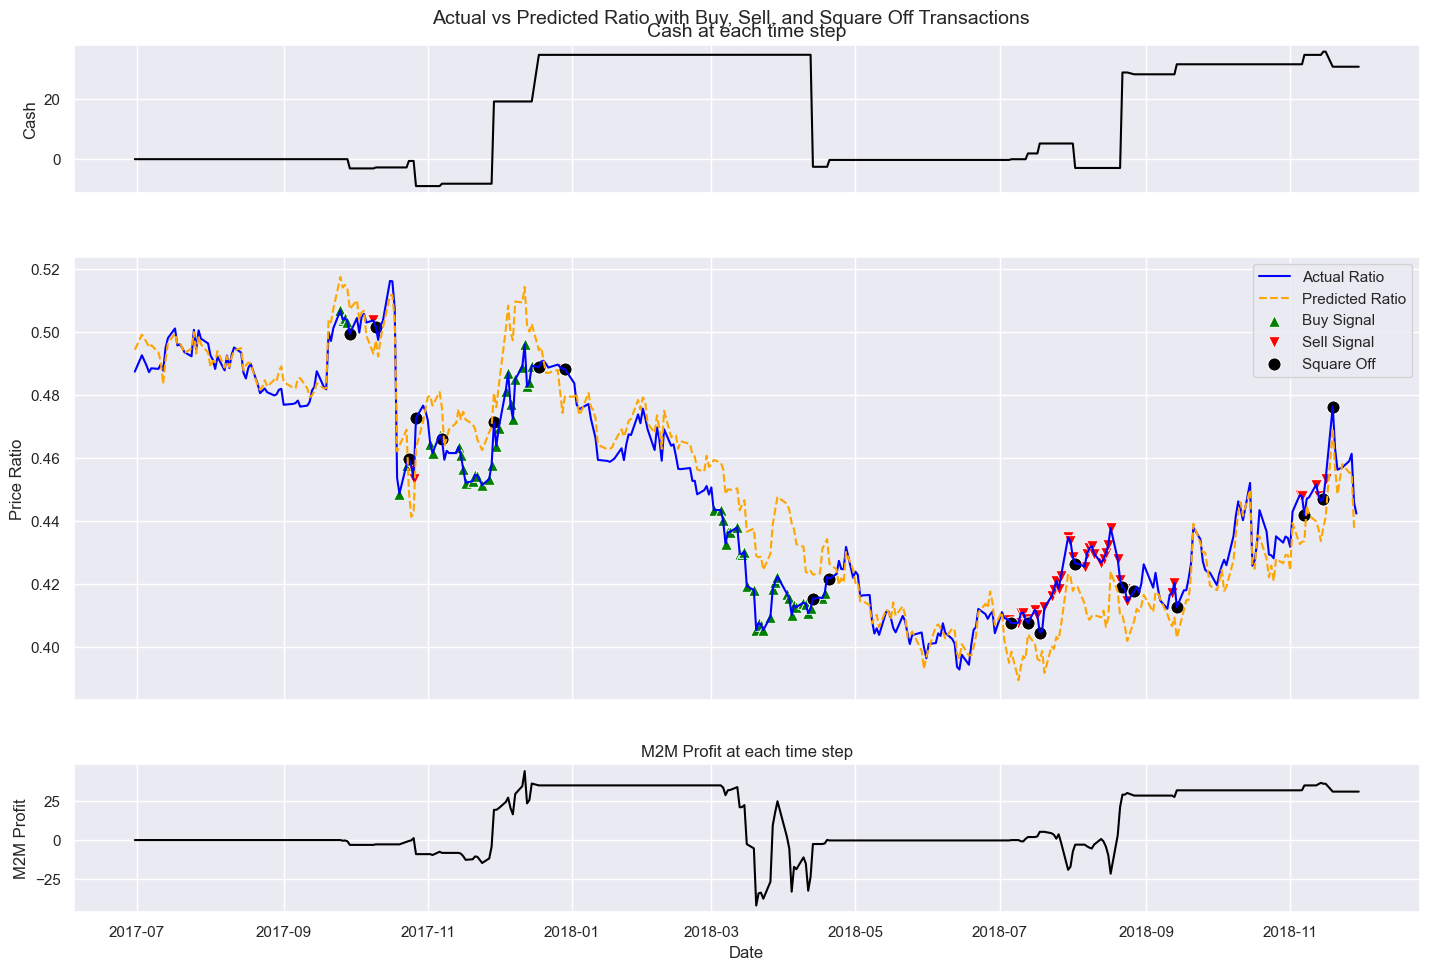

In [68]:
# Plot the ratio, predicted_ratio, and transactions
import seaborn as sns

buy_signals = results[1]
sell_signals = results[2]
square_off_signals = results[3]

plt.rc('figure', figsize=(15, 10))

fig, axes = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 3, 1]}, sharex=True)
fig.tight_layout(pad=3)

# Plot cash
plot_cash = axes[0]
sns.lineplot(x=results[4].index, y=results[4], ax=plot_cash, color='black')
plot_cash.grid(True)
plot_cash.set_ylabel('Cash', fontsize=12)
plot_cash.set_title('Cash at each time step', fontsize=14)

# Plot ratio
plot_ratio = axes[1]
sns.lineplot(x=test_data.index, y=test_data['ratio'], ax=plot_ratio, label='Actual Ratio', color='blue')
sns.lineplot(x=test_data.index, y=test_data['predicted_ratio'], ax=plot_ratio, label='Predicted Ratio', color='orange', linestyle='--')

# Plot buy, sell, and square off transactions
sns.scatterplot(x=buy_signals.index, y=test_data.loc[buy_signals.index]['ratio'], ax=plot_ratio, marker='^', color='green', label='Buy Signal', s=70)
sns.scatterplot(x=sell_signals.index, y=test_data.loc[sell_signals.index]['ratio'], ax=plot_ratio, marker='v', color='red', label='Sell Signal', s=70)
sns.scatterplot(x=square_off_signals.index, y=test_data.loc[square_off_signals.index]['ratio'], ax=plot_ratio, marker='o', color='black', label='Square Off', s=90)
# Cosmetics
plot_ratio.set_ylabel('Price Ratio', fontsize=12)
plot_ratio.legend()
plot_ratio.grid(True)

# Plot M2M profit
plot_profit = axes[2]
sns.lineplot(x=results[5].index, y=results[5], ax=plot_profit, color='black')
plot_profit.grid(True)
plot_profit.set_ylabel('M2M Profit', fontsize=12)
plot_profit.set_title('M2M Profit at each time step', fontsize=12)

# Set common x-axis label
plot_profit.set_xlabel('Date', fontsize=12)

plt.suptitle('Actual vs Predicted Ratio with Buy, Sell, and Square Off Transactions', fontsize=14)
plt.show()


Monitoring the cummulative Profit/Loss at the end ofeach Square-Off Transaction

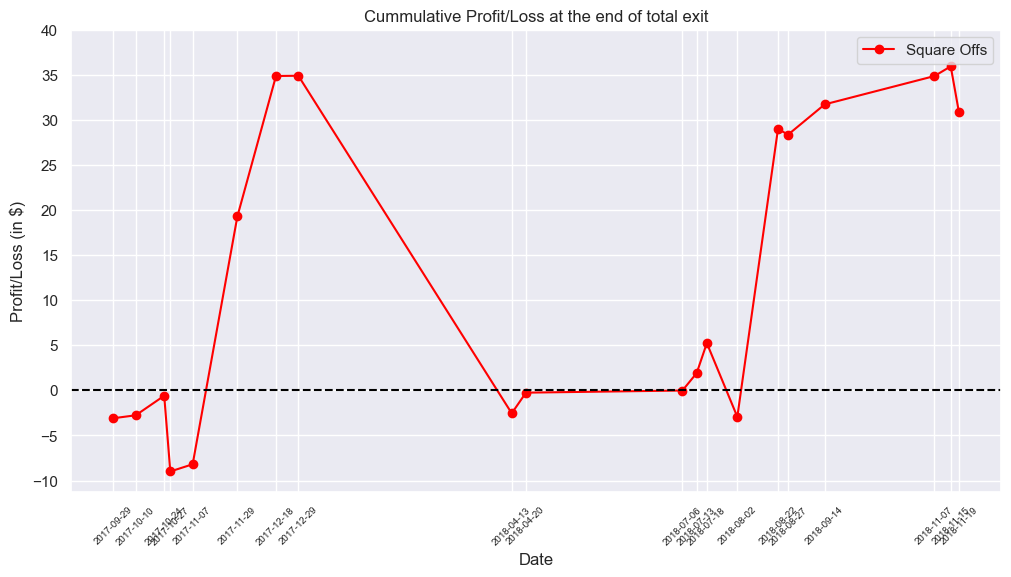

In [69]:
square_offs = results[3]
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(square_offs, label='Square Offs', marker='o', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Profit/Loss (in $)')
plt.xlabel('Date')
plt.yticks(np.arange(-10, 45, 5))
plt.xticks(square_offs.index,rotation=45, fontsize=7)
plt.title('Cummulative Profit/Loss at the end of total exit')
plt.legend()
plt.show()

Monitoring the Exposure in the entire testing period

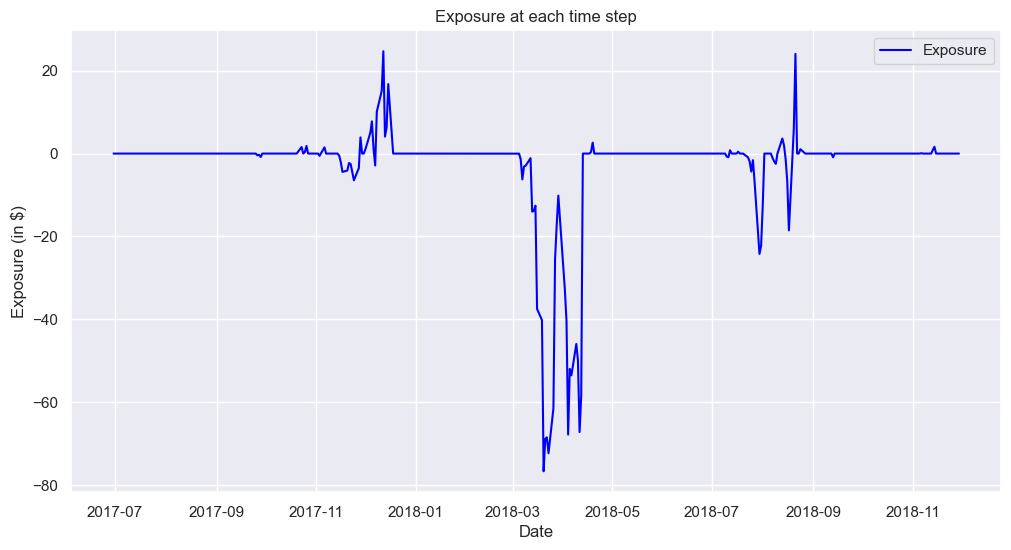

In [70]:
exposures = results[11]
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(exposures, label='Exposure', color='blue')
plt.ylabel('Exposure (in $)')
plt.xlabel('Date')
plt.title('Exposure at each time step')
plt.legend()
plt.show()

The exposure gets very high at times, and this is not ideal since it is a market neutral strategy.

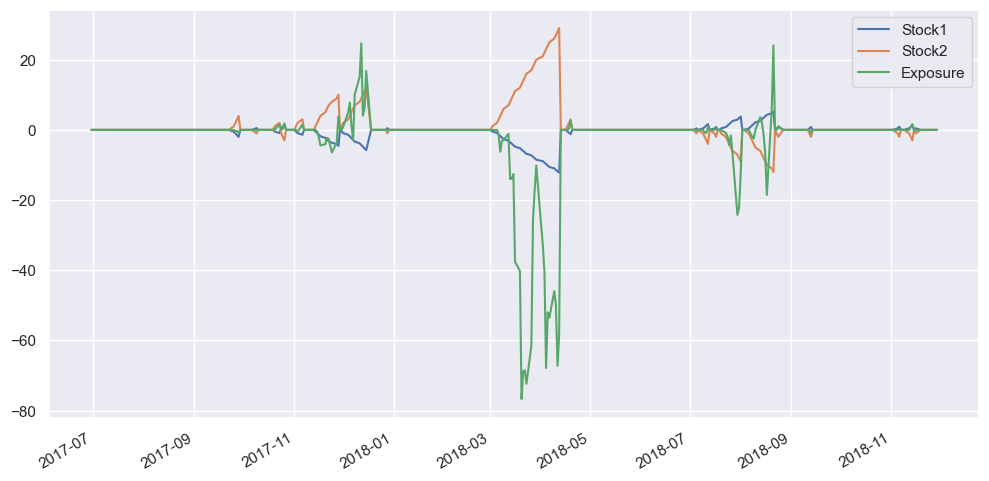

In [71]:
# Note: this is just to visualize, shalln't go into production
plt.figure(figsize=(12,6))
results[12].plot() # Number of stocks of stock1
results[13].plot() # Number of stocks of stock2
results[11].plot() # Exposure
plt.legend(['Stock1', 'Stock2', 'Exposure'])

## Conclusion

1) The strategy generated return of $35 over the testing period of about 16 months, which is not ideal.
2) The maximum drawdown and maximum exposure was \$64 and -\$80 respectively, which is not desirable as we want to keep them as low as possible since this is a market neutral strategy.
3) The hit rate was 52%, which is also abysmal.

## Improvements

The signal generation for trading have to be improved to imporve the performance of the strategy. 

1) The model to generate forecasts of price ratio can be improved. This will allow us to have better signals and thereofore, improve profitability.
2) The signals are generated if there is a significant difference between the predicted price ratio and the current price ratio. However, in the current scenario, we generate signals even when there is about 2% price difference because otherwise, there are far to few signals. This can also be improved by having better predictions.

